In [1]:
%pylab inline
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.optimize import fsolve
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

In [3]:
rcParams['text.usetex'] = True

In [4]:
def completeEWA(N,x,y,Nt,Pix, Piy, alpha, beta, kappa, delta):
    Nold = Nt
    Nt = (1-alpha)*(1-kappa)*Nt+1
    
    x1 = x**(1-alpha)*Nold/Nt
    x2 = exp(beta * ((delta*ones(N) + (1-delta)*x)*dot(Pix,y))/Nt)
    
    y1 = y**(1-alpha)*Nold/Nt
    y2 = exp(beta * ((delta*ones(N) + (1-delta)*y)*dot(Piy,x))/Nt)
    
    Zx =  dot(x1,x2)
    Zy =  dot(y1,y2) 

    x = x1*x2 / Zx
    y = y1*y2 / Zy
    
    return x,y,Nt

def runcompleteEWA(N,maxit,seedpayoff,seedic,alpha,beta,kappa,delta, gamma,Pix=0,Piy=0):        

    if (type(Pix)==type(0) and type(Piy)==type(0)):
        Pix,Piy=initializepayoff(seedpayoff,gamma,N)
        
    recx = zeros((maxit+1 , N))
    recy = zeros((maxit+1 , N))

    x,y = initializestrategies(seedic,N)
    recx[0][:]=x     
    recy[0][:]=y 
    Nt = 1
    
    for step in range(maxit):
        x,y,Nt=completeEWA(N,x,y,Nt,Pix, Piy, alpha, beta, kappa, delta)
        recx[step+1][:]=x
        recy[step+1][:]=y
        
    return recx,recy

#Initial condition for the mixed strategy vectors        
def initializestrategies(seed,N):
    
    #random.seed(seed)
    random.seed(seed)
    x = []
    y = []
    for i in range(N):
        x.append(random.random())
        y.append(random.random())
    x = asarray(x)
    y = asarray(y)
    x = x / sum(x)
    y = y / sum(y)
    return x,y

1.0


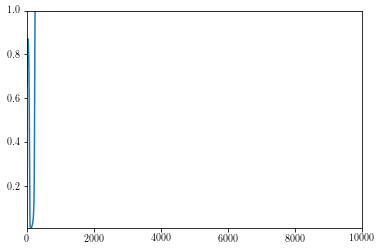

In [342]:
N=2
Pix=array([[4,1],[1,3]])
Piy=array([[-4,0],[0,-3]])
alpha=0.0
beta=0.1
kappa=1.
delta=0.3

maxit=10000
seedpayoff=1
seedic=3
gamma=0

recx,recy=runcompleteEWA(N,maxit,seedpayoff,seedic,alpha,beta,kappa,delta, gamma,Pix,Piy)

plot(recx[:,0])
print(recx[maxit-1,0])

0.6077286003577768


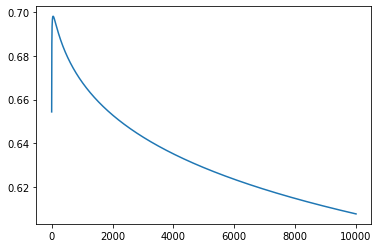

In [61]:
N=2
Pix=array([[4,0],[0,3]])
Piy=array([[-4,0],[0,-3]])
alpha=0.000
beta=0.1
kappa=0.
delta=1

maxit=10000
seedpayoff=1
seedic=3
gamma=0

recx,recy=runcompleteEWA(N,maxit,seedpayoff,seedic,alpha,beta,kappa,delta, gamma,Pix,Piy)

plot(recx[:,0])
print(recx[maxit-1,0])

In [5]:
#Define findsolutions function

def findsolutions(alpha,beta,kappa,A,B,C,D):
    betatilde = beta*(1-(1-alpha)*(1-kappa))
    fx = lambda x: x - betatilde/alpha*(A * tanh(betatilde/alpha * (C * tanh(x)+D)) + B)
    fy = lambda y: y - betatilde/alpha*(C * tanh(betatilde/alpha * (A * tanh(y)+B)) + D)
    solxlist = [] #I will store here the solutions xstar
    solylist = [] #I will store here the solutions ystar
    step = 0.1 #Step to search for the solutions
    initvalue = -10 #Starting point to search for the solutions
    endvalue = abs(initvalue) + step #End point to search for the solutions: the + step is because 
    for ic in arange(initvalue,endvalue,step):
        if abs(ic) >= step: #I need this because if I start at zero, there are numerical problems. I take off the points at distance step
            solx = fsolve(fx,ic)
            soly = fsolve(fy,ic)
            solxlist.append(round(float(solx),5))
            solylist.append(round(float(soly),5))
    solxlist = list(set(list(solxlist))) #Get rid of duplicated solutions
    solylist = list(set(list(solylist))) #Get rid of duplicated solutions
    
    solutionstilde = [] #Find the right couplings (xstar,ystar)
    for solx in solxlist:
        for soly in solylist:
            #print solx
            #print soly
            #print round(solx,2)
            #print round( (1-alpha) * solx + betatilde * (A * tanh(soly) + B) , 2)
            #print round(soly,2)
            #print round( (1-alpha) * soly + betatilde * (C * tanh(solx) + D) , 2)
            s1 = round(solx,2) == round( (1-alpha) * solx + betatilde * (A * tanh(soly) + B) , 2)
            s2 = round(soly,2) == round( (1-alpha) * soly + betatilde * (C * tanh(solx) + D) , 2)
            if s1 and s2:
                solutionstilde.append((solx,soly))
    stable = []
    unstable = []
    for (xtilde,ytilde) in solutionstilde:
        J11 = 1 - alpha
        J12 = A * betatilde / (cosh(ytilde))**2
        J21 = C * betatilde / (cosh(xtilde))**2
        J22 = 1 - alpha
        M=numpy.matrix([[J11, J12],[J21, J22]])
        eigenvalues=linalg.eigvals(M)
        control = 0
        for eigen in eigenvalues:        
            if abs(eigen)>1: 
                control = 1                        
        if control == 1: unstable.append((xtilde,ytilde))
        if control == 0: stable.append((xtilde,ytilde))
    return solutionstilde,unstable,stable

In [6]:
A=7/4
B=1/4
C=A
D=B
kappa=0
alpha=0.5
beta=10

solutionstilde,unstable,stable = findsolutions(alpha,beta,kappa,A,B,C,D)
sol = 1/(1+exp(-2*array(stable)))
sol

array([[9.35762297e-14, 9.35762297e-14],
       [1.00000000e+00, 1.00000000e+00]])

In [6]:
def search_parameter_space(A,B,C,D,kappa,alphalist,betalist,ngrid):
    
    filename = "./transitions/taxonomy_A_"+str(A)+"_B_"+str(B)+"_C_"+\
            str(C)+"_D_"+str(D)+"_k_"+str(kappa)+"_alpha_beta.pickle"
    
    taxonomy = [[np.nan for x in range(ngrid+1)] for x in range(ngrid+1)] 
    i=0
    j=0
    maxbeta=max(betalist)
    
    for beta in betalist:
        j = 0
        for alpha in alphalist:       
            solutionstilde,unstable,stable = findsolutions(alpha,beta,kappa,A,B,C,D)
            sol = 1/(1+exp(-2*array(stable)))

            if sol.shape[0]<=2:
                taxonomy[i][j] = sol
            
            j = j + 1
        i = i + 1   
        
    outfile = open(filename,'wb')
    pickle.dump(taxonomy,outfile)
    outfile.close()
    
    return taxonomy

In [7]:
A=7/4
B=1/4
C=A
D=B
for kappa in [0,0.25,0.5,0.75,1]:
    ngrid = 100

    alphalist=linspace(0,1,ngrid+1)
    betalist=linspace(2,0,ngrid+1)

    taxonomy = search_parameter_space(A,B,C,D,kappa,alphalist,betalist,ngrid)

C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Users\marco\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\marco\anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_

In [8]:
A=1/4
B=7/4
C=A
D=B
for kappa in [0,0.25,0.5,0.75,1]:
    ngrid = 100

    alphalist=linspace(0,1,ngrid+1)
    betalist=linspace(2,0,ngrid+1)

    taxonomy = search_parameter_space(A,B,C,D,kappa,alphalist,betalist,ngrid)

C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in double_scalars
C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in double_scalars


In [9]:
A=7/4
B=1/4
C=-A
D=-B
for kappa in [0,0.25,0.5,0.75,1]:
    ngrid = 100

    alphalist=linspace(0,1,ngrid+1)
    betalist=linspace(2,0,ngrid+1)

    taxonomy = search_parameter_space(A,B,C,D,kappa,alphalist,betalist,ngrid)

C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


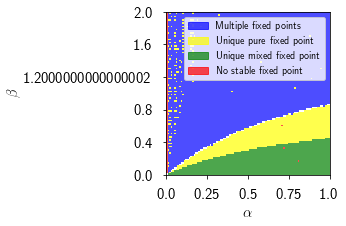

In [234]:
A=7/4
B=1/4
C=A
D=B
kappa=0.5

filename = "./transitions/taxonomy_A_"+str(A)+"_B_"+str(B)+"_C_"+\
            str(C)+"_D_"+str(D)+"_k_"+str(kappa)+"_alpha_beta.pickle"

with open(filename, 'rb') as f:
    solutions = pickle.load(f)
    
ngrid = len(solutions) - 1
taxonomy = [[np.nan for x in range(ngrid+1)] for x in range(ngrid+1)] 
i=0
j=0
maxbeta=max(betalist)

for beta in betalist:
    j = 0
    for alpha in alphalist:       
        
        sol = solutions[i][j]
        
        if isinstance(sol,float): 
            j = j + 1
            continue
        
        if sol.shape[0]!=0:
            if sol.shape[0]==2: taxonomy[i][j]=0
            if sol.shape[0]==1 & (abs(sol[0][0]-0.5)>0.2): taxonomy[i][j]=1
            if sol.shape[0]==1 & (abs(sol[0][0]-0.5)<0.2): taxonomy[i][j]=2
        else:
            taxonomy[i][j] = 3
        j = j + 1
    i = i + 1   
    
fig=figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1) 
vmax=3.
cmap = LinearSegmentedColormap.from_list('mycmap', [(0 / vmax, 'blue'),
                                                    (1 / vmax, 'yellow'),
                                                    (2 / vmax, 'green'),
                                                    (3 / vmax, 'red')]
                                        )
#pcolor(Alist, Blist, array(taxonomy), cmap=cmap, vmin=0, vmax=3.0)
imshow(taxonomy, cmap=cmap, vmin=0, vmax=3.0,interpolation="none",extent=[0,1,0,1], alpha=0.7)

xlabel(r'$\alpha$',fontsize=15)
ylabel(r'$\beta$',fontsize=15)
#h.set_rotation(1)
ax.set_xticks(linspace(0,1,5))
ax.set_xticklabels(linspace(0,1,5), fontsize = 15)
ax.set_yticks(linspace(0,1,6))
ax.set_yticklabels(linspace(0,maxbeta,6), fontsize = 15)
#ax.yaxis.labelpad = 40
ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=10)

multiplefp = mpatches.Patch(color='blue', alpha=0.7, label='Multiple fixed points')
uniquepurefp = mpatches.Patch(color='yellow',alpha=0.7, label='Unique pure fixed point')
uniquemixedfp = mpatches.Patch(color='green', alpha=0.7,label='Unique mixed fixed point')
nomixedfp = mpatches.Patch(color='red', alpha=0.7,label='No stable fixed point')

legend(handles=[multiplefp,uniquepurefp,uniquemixedfp,nomixedfp],fontsize = 10)

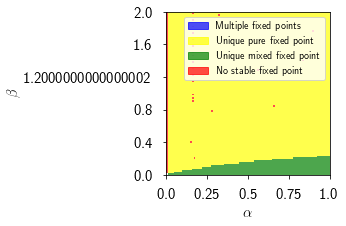

In [235]:
A=1/4
B=7/4
C=A
D=B
kappa=0.5

filename = "./transitions/taxonomy_A_"+str(A)+"_B_"+str(B)+"_C_"+\
            str(C)+"_D_"+str(D)+"_k_"+str(kappa)+"_alpha_beta.pickle"

with open(filename, 'rb') as f:
    solutions = pickle.load(f)
    
ngrid = len(solutions) - 1
taxonomy = [[np.nan for x in range(ngrid+1)] for x in range(ngrid+1)] 
i=0
j=0
maxbeta=max(betalist)

for beta in betalist:
    j = 0
    for alpha in alphalist:       
        
        sol = solutions[i][j]
        
        if isinstance(sol,float): 
            j = j + 1
            continue
        
        if sol.shape[0]!=0:
            if sol.shape[0]==2: taxonomy[i][j]=0
            if sol.shape[0]==1 & (abs(sol[0][0]-0.5)>0.2): taxonomy[i][j]=1
            if sol.shape[0]==1 & (abs(sol[0][0]-0.5)<0.2): taxonomy[i][j]=2
        else:
            taxonomy[i][j] = 3
        j = j + 1
    i = i + 1   
    
fig=figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1) 
vmax=3.
cmap = LinearSegmentedColormap.from_list('mycmap', [(0 / vmax, 'blue'),
                                                    (1 / vmax, 'yellow'),
                                                    (2 / vmax, 'green'),
                                                    (3 / vmax, 'red')]
                                        )
#pcolor(Alist, Blist, array(taxonomy), cmap=cmap, vmin=0, vmax=3.0)
imshow(taxonomy, cmap=cmap, vmin=0, vmax=3.0,interpolation="none",extent=[0,1,0,1], alpha=0.7)

xlabel(r'$\alpha$',fontsize=15)
ylabel(r'$\beta$',fontsize=15)
#h.set_rotation(1)
ax.set_xticks(linspace(0,1,5))
ax.set_xticklabels(linspace(0,1,5), fontsize = 15)
ax.set_yticks(linspace(0,1,6))
ax.set_yticklabels(linspace(0,maxbeta,6), fontsize = 15)
#ax.yaxis.labelpad = 40
ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=10)

multiplefp = mpatches.Patch(color='blue', alpha=0.7, label='Multiple fixed points')
uniquepurefp = mpatches.Patch(color='yellow',alpha=0.7, label='Unique pure fixed point')
uniquemixedfp = mpatches.Patch(color='green', alpha=0.7,label='Unique mixed fixed point')
nomixedfp = mpatches.Patch(color='red', alpha=0.7,label='No stable fixed point')

legend(handles=[multiplefp,uniquepurefp,uniquemixedfp,nomixedfp],fontsize = 10)

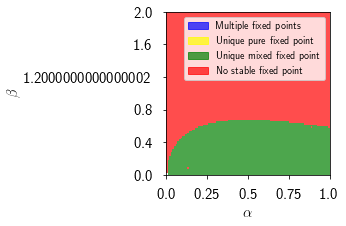

In [236]:
A=7/4
B=1/4
C=-A
D=-B
kappa=0.5

filename = "./transitions/taxonomy_A_"+str(A)+"_B_"+str(B)+"_C_"+\
            str(C)+"_D_"+str(D)+"_k_"+str(kappa)+"_alpha_beta.pickle"

with open(filename, 'rb') as f:
    solutions = pickle.load(f)
    
ngrid = len(solutions) - 1
taxonomy = [[np.nan for x in range(ngrid+1)] for x in range(ngrid+1)] 
i=0
j=0
maxbeta=max(betalist)

for beta in betalist:
    j = 0
    for alpha in alphalist:       
        
        sol = solutions[i][j]
        
        if isinstance(sol,float): 
            j = j + 1
            continue
        
        if sol.shape[0]!=0:
            if sol.shape[0]==2: taxonomy[i][j]=0
            if sol.shape[0]==1 & (abs(sol[0][0]-0.5)>0.2): taxonomy[i][j]=1
            if sol.shape[0]==1 & (abs(sol[0][0]-0.5)<0.2): taxonomy[i][j]=2
        else:
            taxonomy[i][j] = 3
        j = j + 1
    i = i + 1   
    
fig=figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1) 
vmax=3.
cmap = LinearSegmentedColormap.from_list('mycmap', [(0 / vmax, 'blue'),
                                                    (1 / vmax, 'yellow'),
                                                    (2 / vmax, 'green'),
                                                    (3 / vmax, 'red')]
                                        )
#pcolor(Alist, Blist, array(taxonomy), cmap=cmap, vmin=0, vmax=3.0)
imshow(taxonomy, cmap=cmap, vmin=0, vmax=3.0,interpolation="none",extent=[0,1,0,1], alpha=0.7)

xlabel(r'$\alpha$',fontsize=15)
ylabel(r'$\beta$',fontsize=15)
#h.set_rotation(1)
ax.set_xticks(linspace(0,1,5))
ax.set_xticklabels(linspace(0,1,5), fontsize = 15)
ax.set_yticks(linspace(0,1,6))
ax.set_yticklabels(linspace(0,maxbeta,6), fontsize = 15)
#ax.yaxis.labelpad = 40
ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=10)

multiplefp = mpatches.Patch(color='blue', alpha=0.7, label='Multiple fixed points')
uniquepurefp = mpatches.Patch(color='yellow',alpha=0.7, label='Unique pure fixed point')
uniquemixedfp = mpatches.Patch(color='green', alpha=0.7,label='Unique mixed fixed point')
nomixedfp = mpatches.Patch(color='red', alpha=0.7,label='No stable fixed point')

legend(handles=[multiplefp,uniquepurefp,uniquemixedfp,nomixedfp],fontsize = 10)

In [32]:
solutions[0][0].shape[0]

0

In [100]:
import matplotlib.lines as mlines
import matplotlib.patches as patches


In [201]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0


C:\Users\marco\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


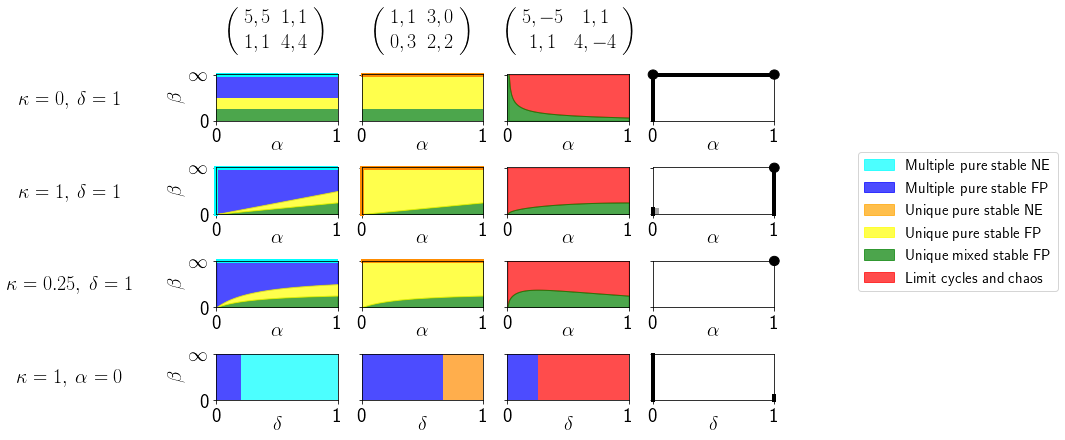

In [441]:
color_multiple_nash = "cyan"
color_multiple_fp = "blue"
color_single_nash = "darkorange"
color_single_pure_fp = "yellow"
color_single_mixed_fp = "green"
color_no_fp = "red"

alpha=0.7


fig, axs = plt.subplots(4,4, sharey=True,figsize=(10,6))
plt.subplots_adjust( 
                    hspace=1.)


fontsize=20

ax = axs[0,0]
ax.set_xlabel(r'$\alpha$',fontsize=fontsize,labelpad=-10)
ax.set_xticks(linspace(0,1,2))
ax.set_xticklabels(["0","1"], fontsize = fontsize)
r = patches.Rectangle((0, 0.5), 1, 0.5, linewidth=0, edgecolor=color_multiple_fp, facecolor=color_multiple_fp,alpha=alpha)
ax.add_patch(r)
r = patches.Rectangle((0, 0.25), 1, 0.25, linewidth=0, edgecolor=color_single_pure_fp, facecolor=color_single_pure_fp,\
                     alpha=alpha)
ax.add_patch(r)
r = patches.Rectangle((0, 0.), 1, 0.25, linewidth=0, edgecolor=color_single_mixed_fp, facecolor=color_single_mixed_fp,\
                     alpha=alpha)
ax.add_patch(r)
l = mlines.Line2D([0.01,0.99], [1,1],color=color_multiple_nash,clip_on=False,linewidth=4)
ax.add_line(l)
ax.set_ylabel(r'$\beta$',fontsize=fontsize)
ax.set_yticks(linspace(0,1,2))
ax.set_yticklabels(["0",r'$\infty$'], fontsize = fontsize)


ax = axs[0,1]
ax.set_xlabel(r'$\alpha$',fontsize=fontsize,labelpad=-10)
ax.set_xticks(linspace(0,1,2))
ax.set_xticklabels(["0","1"], fontsize = fontsize)
r = patches.Rectangle((0, 0.25), 1, 0.75, linewidth=0, edgecolor=color_single_pure_fp, facecolor=color_single_pure_fp,\
                     alpha=alpha)
ax.add_patch(r)
r = patches.Rectangle((0, 0.), 1, 0.25, linewidth=0, edgecolor=color_single_mixed_fp, facecolor=color_single_mixed_fp,\
                     alpha=alpha)
ax.add_patch(r)
l = mlines.Line2D([0.01,0.99], [1,1],color=color_single_nash,clip_on=False,linewidth=4)
ax.add_line(l)

ax = axs[0,2]
x=linspace(0,1,101)
y=sqrt(2*x-x**2)/x/14
#fill_between(x, y,color='g',alpha=.5,where=x<=y)
ax.fill_between(x, y, 1,color=color_no_fp,alpha=alpha)
ax.fill_between(x, y, color=color_single_mixed_fp,alpha=alpha)
r = patches.Rectangle((0, 0), x[1], 1, linewidth=0, edgecolor=color_single_mixed_fp, facecolor=color_single_mixed_fp,\
                     alpha=alpha)
ax.add_patch(r)
ax.set_xlabel(r'$\alpha$',fontsize=fontsize,labelpad=-10)
ax.set_xticks(linspace(0,1,2))
ax.set_xticklabels(["0","1"], fontsize = fontsize)


ax = axs[1,0]
ax.set_xlabel(r'$\alpha$',fontsize=fontsize,labelpad=-10)
ax.set_xticks(linspace(0,1,2))
ax.set_xticklabels(["0","1"], fontsize = fontsize)
x=linspace(0,1,101)
y=0.25*x
ax.fill_between(x, y, color=color_single_mixed_fp,alpha=alpha)
y1=0.5*x
ax.fill_between(x, y1, 1, color=color_multiple_fp,alpha=alpha)
ax.fill_between(x, y, y1, color=color_single_pure_fp,alpha=alpha)
l = mlines.Line2D([0.01,0.99], [1,1],color=color_multiple_nash,clip_on=False,linewidth=4)
ax.add_line(l)
l = mlines.Line2D([0.0,0], [0,1],color=color_multiple_nash,clip_on=False,linewidth=4)
ax.add_line(l)
ax.set_ylabel(r'$\beta$',fontsize=fontsize)
ax.set_yticks(linspace(0,1,2))
ax.set_yticklabels(["0",r'$\infty$'], fontsize = fontsize)


ax = axs[1,1]
ax.set_xlabel(r'$\alpha$',fontsize=fontsize,labelpad=-10)
ax.set_xticks(linspace(0,1,2))
ax.set_xticklabels(["0","1"], fontsize = fontsize)
x=linspace(0,1,101)
y=0.25*x
ax.fill_between(x, y, color=color_single_mixed_fp,alpha=alpha)
ax.fill_between(x, y, 1, color=color_single_pure_fp,alpha=alpha)
l = mlines.Line2D([0.01,0.99], [1,1],color=color_single_nash,clip_on=False,linewidth=4)
ax.add_line(l)
l = mlines.Line2D([0.0,0], [0,1],color=color_single_nash,clip_on=False,linewidth=4)
ax.add_line(l)


ax = axs[1,2]
ax.set_xlabel(r'$\alpha$',fontsize=fontsize,labelpad=-10)
ax.set_xticks(linspace(0,1,2))
ax.set_xticklabels(["0","1"], fontsize = fontsize)
x=linspace(0,1,101)
y=sqrt(2*x-x**2)/4
#fill_between(x, y,color='g',alpha=.5,where=x<=y)
ax.fill_between(x, y, 1,color=color_no_fp,alpha=alpha)
ax.fill_between(x, y, color=color_single_mixed_fp,alpha=alpha)


ax = axs[2,0]
ax.set_xlabel(r'$\alpha$',fontsize=fontsize,labelpad=-10)
ax.set_xticks(linspace(0,1,2))
ax.set_xticklabels(["0","1"], fontsize = fontsize)
x=linspace(0,1,101)
kappa=0.25
y=0.25*x/(1-(1-x)*(1-kappa))
ax.fill_between(x, y, color=color_single_mixed_fp,alpha=alpha)
y1=0.5*x/(1-(1-x)*(1-kappa))
ax.fill_between(x, y1, 1, color=color_multiple_fp,alpha=alpha)
ax.fill_between(x, y, y1, color=color_single_pure_fp,alpha=alpha)
l = mlines.Line2D([0.01,0.99], [1,1],color=color_multiple_nash,clip_on=False,linewidth=4)
ax.add_line(l)
ax.set_ylabel(r'$\beta$',fontsize=fontsize)
ax.set_yticks(linspace(0,1,2))
ax.set_yticklabels(["0",r'$\infty$'], fontsize = fontsize)


ax = axs[2,1]
ax.set_xlabel(r'$\alpha$',fontsize=fontsize,labelpad=-10)
ax.set_xticks(linspace(0,1,2))
ax.set_xticklabels(["0","1"], fontsize = fontsize)
x=linspace(0,1,101)
y=0.25*x/(1-(1-x)*(1-kappa))
ax.fill_between(x, y, color=color_single_mixed_fp,alpha=alpha)
ax.fill_between(x, y, 1, color=color_single_pure_fp,alpha=alpha)
l = mlines.Line2D([0.01,0.99], [1,1],color=color_single_nash,clip_on=False,linewidth=4)
ax.add_line(l)


ax = axs[2,2]
ax.set_xlabel(r'$\alpha$',fontsize=fontsize,labelpad=-10)
ax.set_xticks(linspace(0,1,2))
ax.set_xticklabels(["0","1"], fontsize = fontsize)
x=linspace(0,1,101)
kappa=0.25
y=sqrt(2*x-x**2)/(1-(1-x)*(1-kappa))/4
#fill_between(x, y,color='g',alpha=.5,where=x<=y)
ax.fill_between(x, y, 1,color=color_no_fp,alpha=alpha)
ax.fill_between(x, y, color=color_single_mixed_fp,alpha=alpha)

ax = axs[3,0]
ax.set_xlabel(r'$\delta$',fontsize=fontsize,labelpad=-10)
ax.set_xticks(linspace(0,1,2))
ax.set_xticklabels(["0","1"], fontsize = fontsize)
ax.set_ylabel(r'$\beta$',fontsize=fontsize)
ax.set_yticks(linspace(0,1,2))
ax.set_yticklabels(["0",r'$\infty$'], fontsize = fontsize)
r = patches.Rectangle((0, 0.), 0.2, 1, linewidth=0, edgecolor=color_multiple_fp, facecolor=color_multiple_fp,\
                     alpha=alpha)
ax.add_patch(r)
r = patches.Rectangle((0.2, 0.), 0.8, 1, linewidth=0, edgecolor=color_multiple_nash, facecolor=color_multiple_nash,\
                     alpha=alpha)
ax.add_patch(r)

ax = axs[3,1]
ax.set_xlabel(r'$\delta$',fontsize=fontsize,labelpad=-10)
ax.set_xticks(linspace(0,1,2))
ax.set_xticklabels(["0","1"], fontsize = fontsize)
r = patches.Rectangle((0, 0.), 2/3, 1, linewidth=0, edgecolor=color_multiple_fp, facecolor=color_multiple_fp,\
                     alpha=alpha)
ax.add_patch(r)
r = patches.Rectangle((2/3, 0.), 1/3, 1, linewidth=0, edgecolor=color_single_nash, facecolor=color_single_nash,\
                     alpha=alpha)
ax.add_patch(r)

ax = axs[3,2]
ax.set_xlabel(r'$\delta$',fontsize=fontsize,labelpad=-10)
ax.set_xticks(linspace(0,1,2))
ax.set_xticklabels(["0","1"], fontsize = fontsize)
r = patches.Rectangle((0, 0.), 0.25, 1, linewidth=0, edgecolor=color_multiple_fp, facecolor=color_multiple_fp,\
                     alpha=alpha)
ax.add_patch(r)
r = patches.Rectangle((0.25, 0.), 0.75, 1, linewidth=0, edgecolor=color_no_fp, facecolor=color_no_fp,\
                     alpha=alpha)
ax.add_patch(r)

ax = axs[0,3]
ax.set_xlabel(r'$\alpha$',fontsize=fontsize,labelpad=-10)
ax.set_xticks(linspace(0,1,2))
ax.set_xticklabels(["0","1"], fontsize = fontsize)
l = mlines.Line2D([0.01,0.99], [1,1],color="k",clip_on=False,linewidth=4)
ax.add_line(l)
l = mlines.Line2D([0.0,0.0], [0.01,0.99],color="k",clip_on=False,linewidth=4)
ax.add_line(l)
c = patches.Ellipse((1,1), 0.08, 0.2, color='k',clip_on=False)
ax.add_patch(c)
c = patches.Ellipse((0,1), 0.08, 0.2, color='k',clip_on=False)
ax.add_patch(c)


ax = axs[1,3]
ax.set_xlabel(r'$\alpha$',fontsize=fontsize,labelpad=-10)
ax.set_xticks(linspace(0,1,2))
ax.set_xticklabels(["0","1"], fontsize = fontsize)
c = patches.Ellipse((1,1), 0.08, 0.2, color='k',clip_on=False)
ax.add_patch(c)
l = mlines.Line2D([0.0,0.0], [0.01,0.1],color="k",clip_on=False,linewidth=4)
ax.add_line(l)
l = mlines.Line2D([1,1], [0.01,0.99],color="k",clip_on=False,linewidth=4)
ax.add_line(l)
r = patches.Rectangle((0, 0.), 0.05, 0.14, linewidth=0, edgecolor="black", facecolor="grey",\
                     alpha=0.7)
ax.add_patch(r)

ax = axs[2,3]
ax.set_xlabel(r'$\alpha$',fontsize=fontsize,labelpad=-10)
ax.set_xticks(linspace(0,1,2))
ax.set_xticklabels(["0","1"], fontsize = fontsize)
c = patches.Ellipse((1,1), 0.08, 0.2, color='k',clip_on=False)
ax.add_patch(c)

ax = axs[3,3]
ax.set_xlabel(r'$\delta$',fontsize=fontsize,labelpad=-10)
ax.set_xticks(linspace(0,1,2))
ax.set_xticklabels(["0","1"], fontsize = fontsize)
l = mlines.Line2D([1,1], [0.01,0.1],color="k",clip_on=False,linewidth=4)
ax.add_line(l)
l = mlines.Line2D([0.0,0.0], [0.01,0.99],color="k",clip_on=False,linewidth=4)
ax.add_line(l)


plt.text(-3.5,8., r'$\left( {\begin{array}{cc} 5,5 & 1,1 \\       1,1 & 4,4   \end{array} } \right)$',\
         fontsize=20,va="center")

plt.text(-2.3,8, r'$\left( {\begin{array}{cc} 1,1 & 3,0 \\       0,3 & 2,2   \end{array} } \right)$',\
         fontsize=20,va="center")

plt.text(-1.21,8, r'$\left( {\begin{array}{cc} 5,-5 & 1,1 \\       1,1 & 4,-4    \end{array} } \right)$',\
         fontsize=20,va="center")

plt.text(-4.8,6.5, r'$\kappa=0, \hspace{5pt} \delta=1$',\
         fontsize=20,va="center",ha="center")

plt.text(-4.8,4.5, r'$\kappa=1, \hspace{5pt} \delta=1$',\
         fontsize=20,va="center",ha="center")

plt.text(-4.8,2.5, r'$\kappa=0.25, \hspace{5pt} \delta=1$',\
         fontsize=20,va="center",ha="center")

plt.text(-4.8,0.5, r'$\kappa=1, \hspace{5pt} \alpha=0$',\
         fontsize=20,va="center",ha="center")

unstablefp = mpatches.Patch(color='red', alpha=0.7, label='Limit cycles and chaos')
uniquepurefp = mpatches.Patch(color='yellow',alpha=0.7, label='Unique pure stable FP')
uniquemixedfp = mpatches.Patch(color='green', alpha=0.7,label='Unique mixed stable FP')
uniquepurene = mpatches.Patch(color='orange', alpha=0.7,label='Unique pure stable NE')
multiplepurene = mpatches.Patch(color='cyan', alpha=0.7,label='Multiple pure stable NE')
multiplepurefp = mpatches.Patch(color='blue', alpha=0.7,label='Multiple pure stable FP')

legend(handles=[multiplepurene,multiplepurefp,uniquepurene,uniquepurefp,\
               uniquemixedfp,unstablefp],fontsize = 15,bbox_to_anchor=(2.4, 5., 1, 0.5))

savefig("../Wp-taxonomy-2x2games/img/summary_figure.pdf", bbox_inches = 'tight')

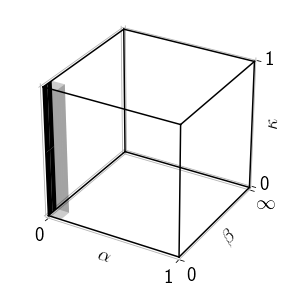

In [424]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations

rcParams['axes.labelsize'] = 20
#rcParams['axes.'] = 20

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the ticks
ax.set_xticks([-1,1]) 
ax.set_yticks([-1,1]) 
ax.set_zticks([-1,1])

ax.tick_params(axis='x', which='major', pad=-3)
ax.tick_params(axis='y', which='major', pad=-3)
ax.tick_params(axis='z', which='major', pad=0)

ax.set_xticklabels(["0","1"],fontsize=20,ha="right") 
ax.set_yticklabels(["0",r'$\infty$'],fontsize=20,ha="left") 
ax.set_zticklabels(["0","1"],fontsize=20,ha="center",va="center") 

# Add the labels
ax.set_xlabel(r'$\alpha$',labelpad=-10 )
ax.set_ylabel(r'$\beta$',labelpad=-10)
ax.set_zlabel(r'$\kappa$',labelpad=-10)

#ax.set_aspect("equal")
#ax.set_axis_off()
# draw cube
r = [-1, 1]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        ax.plot3D(*zip(s, e), color="k")

yy, zz = np.meshgrid(linspace(-1,-0.8,3), linspace(-1,1,3))
xx = yy*0-0.8
ax.plot_surface(xx, yy, zz, alpha=0.2, color="k")  

yy, zz = np.meshgrid(linspace(-1,-0.8,3), linspace(-1,1,3))
xx = yy*0-1
ax.plot_surface(xx, yy, zz, alpha=1, color="k")  
        
xx, zz = np.meshgrid(linspace(-1,-0.8,3), linspace(-1,1,3))
yy = xx*0-1
ax.plot_surface(xx, yy, zz, alpha=0.2, color="k")  

xx, zz = np.meshgrid(linspace(-1,-0.8,3), linspace(-1,1,3))
yy = xx*0-0.8
ax.plot_surface(xx, yy, zz, alpha=0.2, color="k")  
    
    
savefig("../Wp-taxonomy-2x2games/img/learning_cube_1.pdf", bbox_inches = 'tight')

In [415]:
yy, zz = np.meshgrid(linspace(-1,-0.8,3), linspace(0,1,3))
xx = yy*0+0.2
yy

array([[-1. , -0.9, -0.8],
       [-1. , -0.9, -0.8],
       [-1. , -0.9, -0.8]])

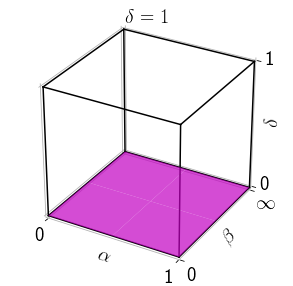

In [437]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations

rcParams['axes.labelsize'] = 20
#rcParams['axes.'] = 20

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the ticks
ax.set_xticks([-1,1]) 
ax.set_yticks([-1,1]) 
ax.set_zticks([-1,1])

ax.tick_params(axis='x', which='major', pad=-3)
ax.tick_params(axis='y', which='major', pad=-3)
ax.tick_params(axis='z', which='major', pad=0)

ax.set_xticklabels(["0","1"],fontsize=20,ha="right") 
ax.set_yticklabels(["0",r'$\infty$'],fontsize=20,ha="left") 
ax.set_zticklabels(["0","1"],fontsize=20,ha="center",va="center") 

# Add the labels
ax.set_xlabel(r'$\alpha$',labelpad=-10 )
ax.set_ylabel(r'$\beta$',labelpad=-10)
ax.set_zlabel(r'$\delta$',labelpad=-10)

#ax.set_aspect("equal")
#ax.set_axis_off()
# draw cube
r = [-1, 1]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        ax.plot3D(*zip(s, e), color="k")

xx,yy = np.meshgrid(linspace(-1,1,3), linspace(-1,1,3))
zz = yy*0-1
ax.plot_surface(xx, yy, zz, alpha=0.7, color="#FF00FF")        
        
plt.title(r'$\delta=1$',fontsize=20)    
    
savefig("../Wp-taxonomy-2x2games/img/learning_cube_2.pdf", bbox_inches = 'tight')

In [411]:
?ax.voxels